# Лабораторна Робота № 8

### Мета: набути навички побудови рішень для розв’язання задач з вчителем, використовуючи методи та моделі глибинного навчання.

### Імпорт бібліотек

In [244]:
import pandas as pd
import numpy as np
import time
from transformers import AutoTokenizer
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import re
import nltk
from keras import models
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
import seaborn as sns

### EDA

In [245]:
df = pd.read_csv('CO2 Emissions_Canada.csv')
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [246]:
df.shape

(7385, 12)

In [247]:
df.isnull().count() #no nulls in dataset

Make                                7385
Model                               7385
Vehicle Class                       7385
Engine Size(L)                      7385
Cylinders                           7385
Transmission                        7385
Fuel Type                           7385
Fuel Consumption City (L/100 km)    7385
Fuel Consumption Hwy (L/100 km)     7385
Fuel Consumption Comb (L/100 km)    7385
Fuel Consumption Comb (mpg)         7385
CO2 Emissions(g/km)                 7385
dtype: int64

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

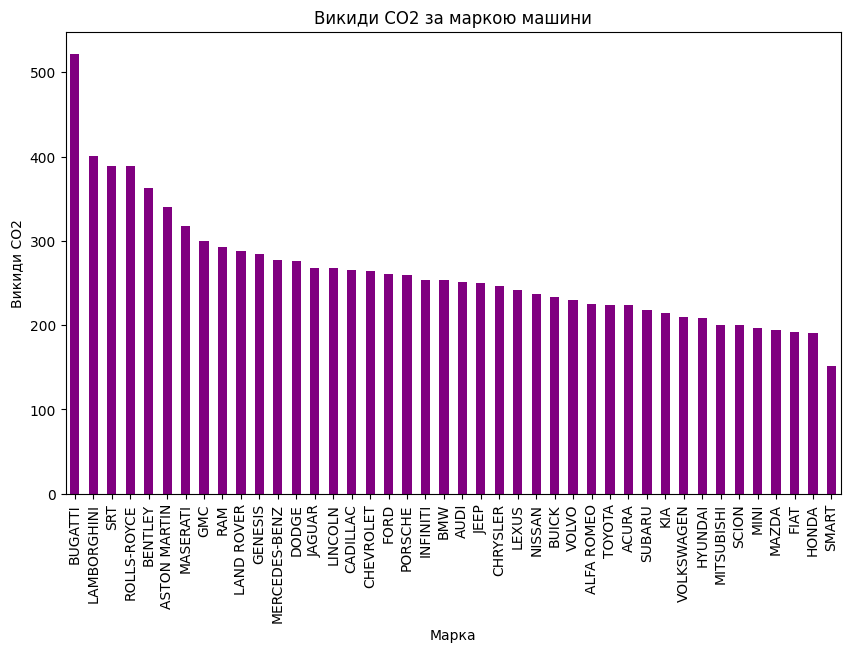

In [249]:
plt.figure(figsize=(10, 6))
df.groupby("Make")["CO2 Emissions(g/km)"].mean().sort_values(ascending=False).plot(kind="bar", color='purple')
plt.title("Викиди СО2 за маркою машини")
plt.xlabel("Марка")
plt.ylabel("Викиди СО2")
plt.show()

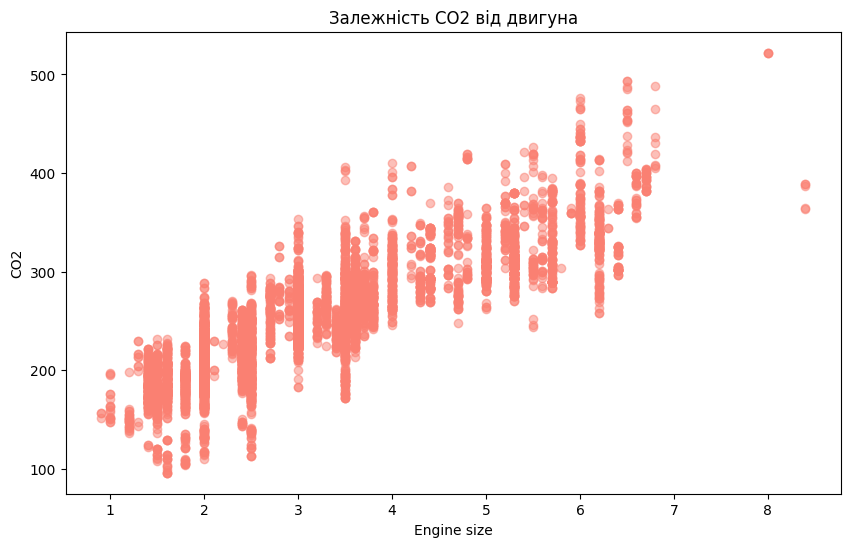

In [250]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Engine Size(L)"], df['CO2 Emissions(g/km)'], color = 'salmon', alpha=0.5)
plt.title("Залежність СО2 від двигуна")
plt.xlabel('Engine size')
plt.ylabel('CO2')
plt.show()

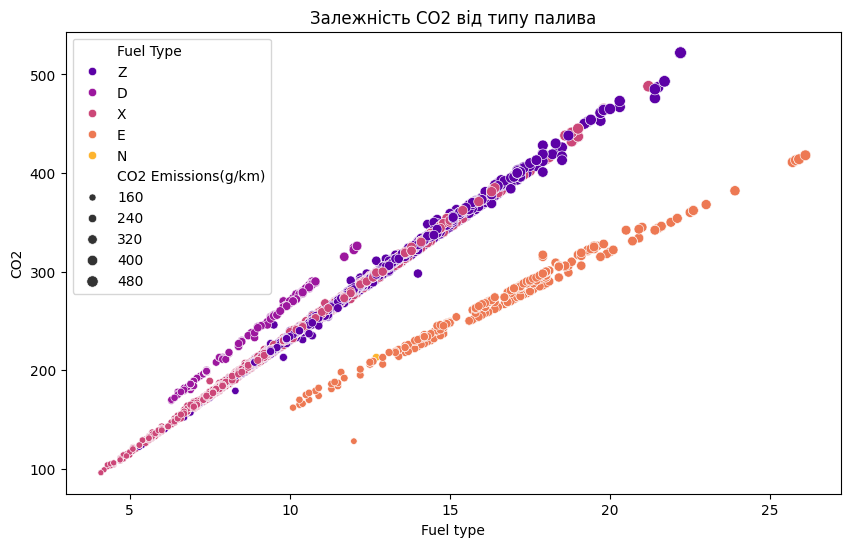

X = Regular gasoline
Z = Premium gasoline
D = Diesel
E = Ethanol (E85)
N = Natural gas


In [251]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Fuel Consumption Comb (L/100 km)", y="CO2 Emissions(g/km)", hue="Fuel Type", size="CO2 Emissions(g/km)", palette="plasma")
plt.title("Залежність СО2 від типу палива")
plt.xlabel('Fuel type')
plt.ylabel('CO2')
plt.show()

print('X = Regular gasoline\nZ = Premium gasoline\nD = Diesel\nE = Ethanol (E85)\nN = Natural gas')

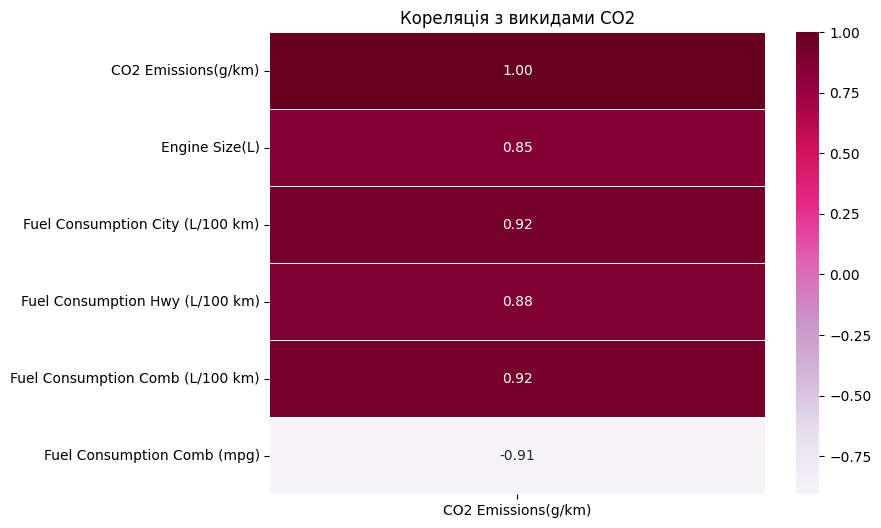

In [252]:
numeric_cols = ["CO2 Emissions(g/km)", "Engine Size(L)", "Fuel Consumption City (L/100 km)",
                         "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
                         "Fuel Consumption Comb (mpg)"]

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['CO2 Emissions(g/km)']], annot=True, cmap='PuRd', fmt='.2f', linewidths=0.5)
plt.title('Кореляція з викидами CO2')
plt.show()

### Підготовка датасету 

In [253]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [254]:
print(df['Fuel Type'].value_counts()) #deleted N

Fuel Type
X    3637
Z    3202
E     370
D     175
N       1
Name: count, dtype: int64


In [255]:
print(df['Model'].value_counts()) #deleted the whole column because useless

Model
F-150 FFV 4X4           32
F-150 FFV               32
MUSTANG                 27
FOCUS FFV               24
SONIC                   20
                        ..
AVENTADOR S ROADSTER     1
HURACAN AWD              1
HURACAN SPYDER AWD       1
LS 500                   1
XC40 T4 AWD              1
Name: count, Length: 2053, dtype: int64


In [256]:
df = df[df['Fuel Type'] != 'N']
df = df.drop(columns=['Model'])

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7384 entries, 0 to 7384
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7384 non-null   object 
 1   Vehicle Class                     7384 non-null   object 
 2   Engine Size(L)                    7384 non-null   float64
 3   Cylinders                         7384 non-null   int64  
 4   Transmission                      7384 non-null   object 
 5   Fuel Type                         7384 non-null   object 
 6   Fuel Consumption City (L/100 km)  7384 non-null   float64
 7   Fuel Consumption Hwy (L/100 km)   7384 non-null   float64
 8   Fuel Consumption Comb (L/100 km)  7384 non-null   float64
 9   Fuel Consumption Comb (mpg)       7384 non-null   int64  
 10  CO2 Emissions(g/km)               7384 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 692.2+ KB


In [258]:
col_categorical = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']
col_numerical = ['Engine Size(L)', 'Cylinders', 
                     'Fuel Consumption City (L/100 km)', 
                     'Fuel Consumption Hwy (L/100 km)', 
                     'Fuel Consumption Comb (L/100 km)', 
                     'Fuel Consumption Comb (mpg)', 
                     'CO2 Emissions(g/km)']

In [259]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df_normalized = df.copy()  # Make a copy of the DataFrame
df_normalized[col_numerical] = scaler.fit_transform(df[col_numerical])

scaler = StandardScaler()
df_normalized[col_numerical] = scaler.fit_transform(df[col_numerical])

In [260]:
df_encoded = pd.get_dummies(df_normalized, columns=col_categorical)

In [261]:
df_encoded.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make_ACURA,Make_ALFA ROMEO,Make_ASTON MARTIN,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_D,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,-0.856625,-0.883322,-0.758877,-1.052685,-0.855624,0.762986,-0.932983,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,-0.561239,-0.883322,-0.387463,-0.603135,-0.475322,0.209858,-0.505713,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,-1.225857,-0.883322,-1.873119,-1.457279,-1.754520,2.837216,-1.958430,True,False,False,...,False,True,False,False,False,False,False,False,False,True
3,0.251072,0.210590,0.041091,0.026234,0.043272,-0.343271,0.075374,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.251072,0.210590,-0.130331,-0.153586,-0.129592,-0.066706,-0.112625,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [262]:
X = df_encoded.drop(columns=['CO2 Emissions(g/km)'])
Y = df_encoded['CO2 Emissions(g/km)']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Вибір моделі

In [263]:
#"конкурс" регресійних моделей
#обираю модель з найнижчим RMSE

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

for name, model in models:
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  
    avg_rmse = np.mean(rmse_scores)
    print(f'{name}: Average RMSE = {avg_rmse:.2f}')

Linear Regression: Average RMSE = 0.08
Ridge Regression: Average RMSE = 0.08
Lasso Regression: Average RMSE = 1.00
Random Forest: Average RMSE = 0.05
Gradient Boosting: Average RMSE = 0.06


### Neural network

In [264]:
x_train.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Make_ACURA,Make_ALFA ROMEO,Make_ASTON MARTIN,Make_AUDI,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_D,Fuel Type_E,Fuel Type_X,Fuel Type_Z
6274,0.620304,0.210590,0.612497,0.565693,0.596439,-0.758117,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1608,-0.561239,-0.883322,-0.787447,-1.052685,-0.890197,0.901268,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2291,-0.856625,-0.883322,-0.358893,-0.872865,-0.544467,0.348140,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3232,-0.487393,-0.883322,-0.701737,-0.603135,-0.682759,0.486422,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3881,1.358769,1.304502,0.926770,0.565693,0.803877,-0.896399,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [265]:
def construct_model(input_shape: tuple[int,...], dim_per_layer: list[int]):
    input_x = layers.Input(shape=input_shape)


    x = layers.Flatten()(input_x)
    for dim in dim_per_layer:
        x = layers.Dense(dim, activation='relu')(x)

    out_x = layers.Dense(1, activation='linear')(x)


    return tf.keras.Model(inputs=input_x, outputs=out_x)


model_nn = construct_model((95,), dim_per_layer=[64, 32])

In [266]:
model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error'])

In [267]:
hist = model_nn.fit(
    x=x_train,
    y=y_train,
    epochs=150,
    batch_size=32,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    validation_data=(x_test, y_test)
)

Epoch 1/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3267 - mean_absolute_error: 0.4100 - val_loss: 0.0560 - val_mean_absolute_error: 0.1592
Epoch 2/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0439 - mean_absolute_error: 0.1411 - val_loss: 0.0259 - val_mean_absolute_error: 0.1050
Epoch 3/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0216 - mean_absolute_error: 0.0979 - val_loss: 0.0149 - val_mean_absolute_error: 0.0819
Epoch 4/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0130 - mean_absolute_error: 0.0775 - val_loss: 0.0110 - val_mean_absolute_error: 0.0712
Epoch 5/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0089 - mean_absolute_error: 0.0655 - val_loss: 0.0085 - val_mean_absolute_error: 0.0639
Epoch 6/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0069 - mean_absolute_error: 0.0579 - val_loss: 0.0070 - val_mean_absolute_error: 0.0588
Epoch 7/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0055 - mean_absolut

In [268]:
y_pred = model_nn.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [269]:
mae_nn = mean_absolute_error(y_test, y_pred) #вимірює середнє значення між правильними і передбаченими лейблами
mse_nn = mean_squared_error(y_test, y_pred) #те саме, але різниця в чисельнику до квадрату
r2_nn = r2_score(y_test, y_pred) #залежить від mse, 1 - хороша модель, 0 - погана

print(f'Mean Absolute Error: ', mae_nn)
print(f'Mean Squared Error: ', mse_nn)
print(f'R-squared: ', r2_nn)

Mean Absolute Error:  0.03843179024017696
Mean Squared Error:  0.0027670459417114776
R-squared:  0.997275013938445


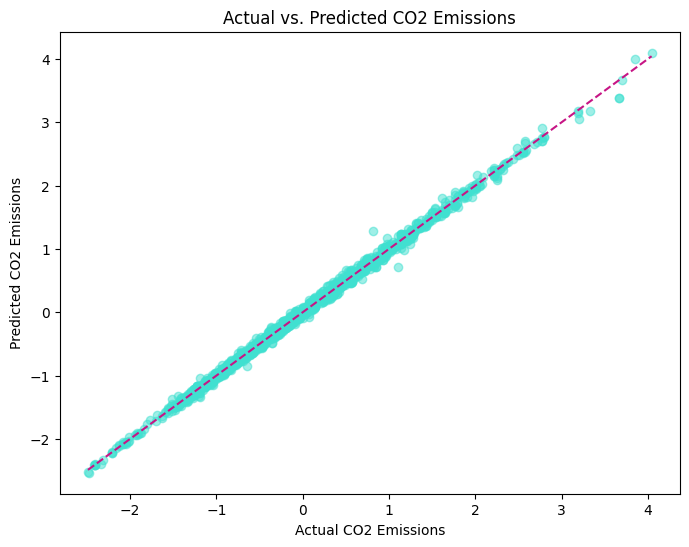

In [270]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="turquoise")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='mediumvioletred')  # Diagonal line for perfect predictions
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Actual vs. Predicted CO2 Emissions')
plt.show()

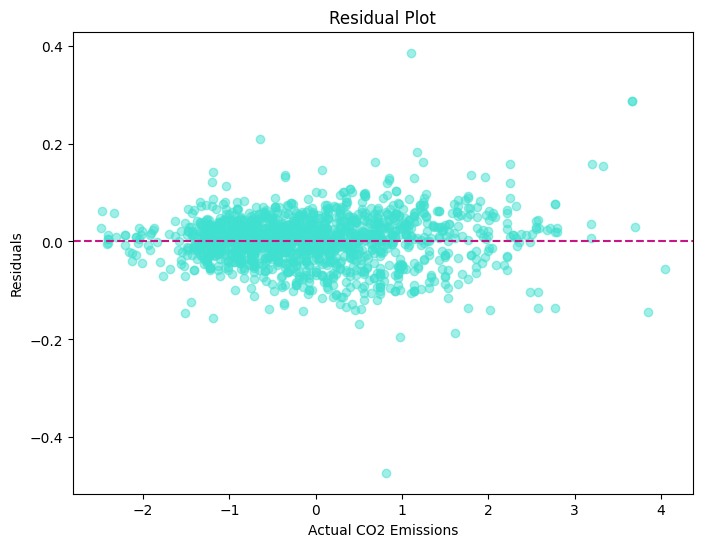

In [271]:
residuals_nn = y_test - y_pred.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_nn, alpha=0.5, color="turquoise")
plt.axhline(y=0, color='mediumvioletred', linestyle='--')  # perfect prediction line
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Random forest model

In [272]:
#random forest model

model=RandomForestRegressor()
model.fit(x_train, y_train)
model.score(x_train, y_train)

0.9994553923032906

In [273]:
model.score(x_test, y_test)

0.9982884566597727

In [274]:
y_pred_forest = model.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_forest) #вимірює середнє значення між правильними і передбаченими лейблами
mse_rf = mean_squared_error(y_test, y_pred_forest) #те саме, але різниця в чисельнику до квадрату
r2_rf = r2_score(y_test, y_pred_forest) #залежить від mse, 1 - хороша модель, 0 - погана

print(f'Mean Absolute Error: ', mae_rf)
print(f'Mean Squared Error: ', mse_rf)
print(f'R-squared: ', r2_rf)

Mean Absolute Error:  0.028163745173520032
Mean Squared Error:  0.0017379608360038924
R-squared:  0.9982884566597727


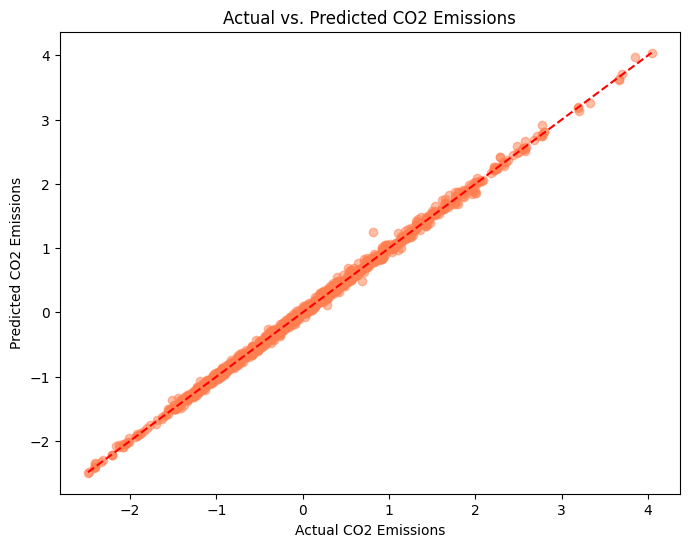

In [275]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_forest, alpha=0.5, color="coral")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line for perfect predictions
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Actual vs. Predicted CO2 Emissions')
plt.show()

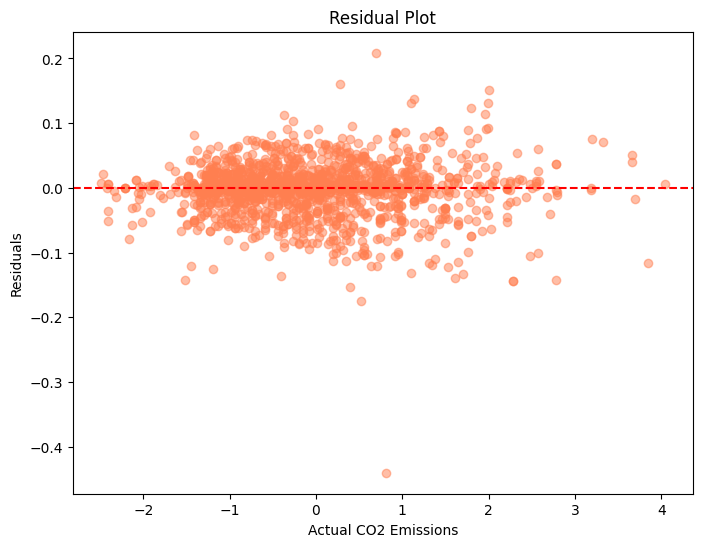

In [276]:
residuals_rf = y_test - y_pred_forest

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_rf, alpha=0.5, color="coral")
plt.axhline(y=0, color='red', linestyle='--')  # perfect prediction line
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Linear regression model

In [277]:
model_linear = LinearRegression()
model_linear.fit(x_train, y_train)
model_linear.score(x_train, y_train)

0.9937366330441548

In [278]:
model_linear.score(x_test, y_test)

0.9936921214896701

In [279]:
y_pred_linear = model_linear.predict(x_test)

mae_lr = mean_absolute_error(y_test, y_pred_linear) #вимірює середнє значення між правильними і передбаченими лейблами
mse_lr = mean_squared_error(y_test, y_pred_linear) #те саме, але різниця в чисельнику до квадрату
r2_lr = r2_score(y_test, y_pred_linear) #залежить від mse, 1 - хороша модель, 0 - погана

print(f'Mean Absolute Error: ', mae_lr)
print(f'Mean Squared Error: ', mse_lr)
print(f'R-squared: ', r2_lr)

Mean Absolute Error:  0.05029322604429876
Mean Squared Error:  0.006405239967670578
R-squared:  0.9936921214896701


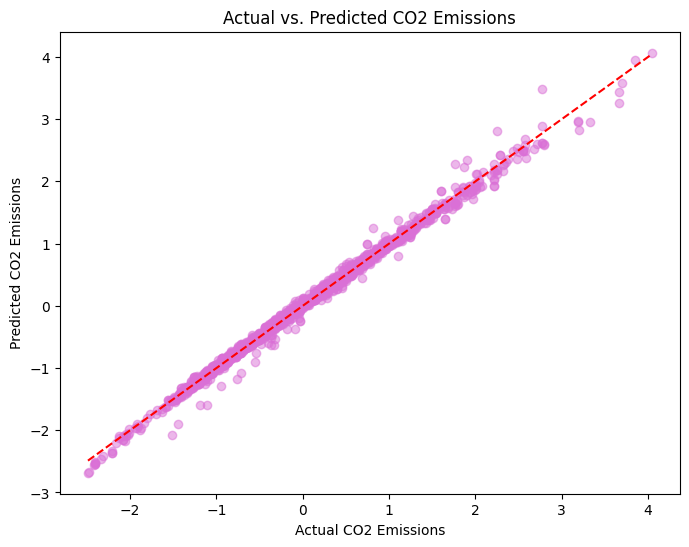

In [280]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5, color="orchid")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line for perfect predictions
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Actual vs. Predicted CO2 Emissions')
plt.show()

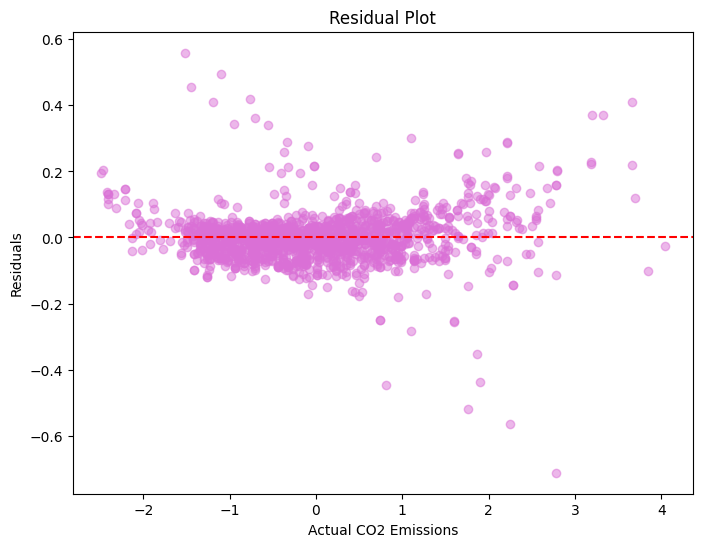

In [281]:
residuals_lr = y_test - y_pred_linear

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_lr, alpha=0.5, color="orchid")
plt.axhline(y=0, color='red', linestyle='--')  # perfect prediction line
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Порівняння результатів

In [282]:
print("\nSummary of Model Performance:")
print(f'Neural Network - MAE: {mae_nn}, MSE: {mse_nn}, R2: {r2_nn}')
print(f'Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}')
print(f'Linear Regression - MAE: {mae_lr}, MSE: {mse_lr}, R2: {r2_lr}')
print(f'\nBest model - {max(r2_nn, r2_rf, r2_lr)}')


Summary of Model Performance:
Neural Network - MAE: 0.03843179024017696, MSE: 0.0027670459417114776, R2: 0.997275013938445
Random Forest - MAE: 0.028163745173520032, MSE: 0.0017379608360038924, R2: 0.9982884566597727
Linear Regression - MAE: 0.05029322604429876, MSE: 0.006405239967670578, R2: 0.9936921214896701

Best model - 0.9982884566597727


Text(0, 0.5, 'Residuals')

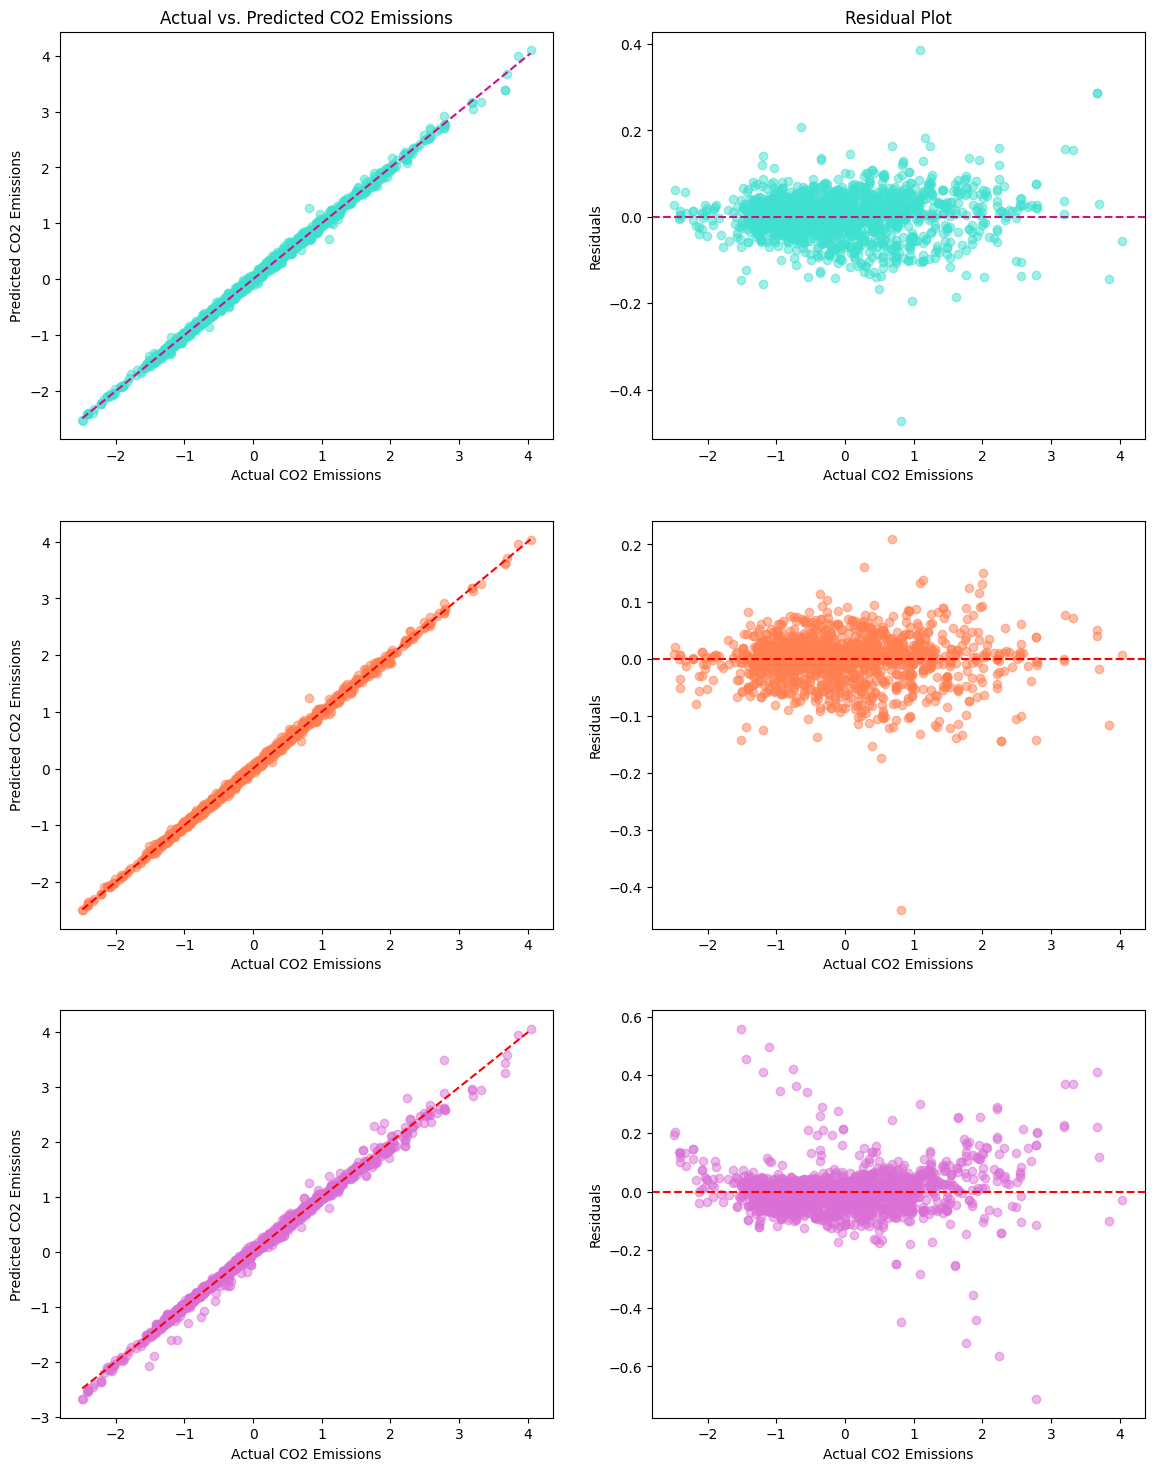

In [283]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

axes[0, 0].scatter(y_test, y_pred, alpha=0.5, color="turquoise")
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='mediumvioletred')  # Diagonal line for perfect predictions
axes[0, 0].set_xlabel('Actual CO2 Emissions')
axes[0, 0].set_ylabel('Predicted CO2 Emissions')
axes[0, 0].set_title('Actual vs. Predicted CO2 Emissions')

axes[0, 1].scatter(y_test, residuals_nn, alpha=0.5, color="turquoise")
axes[0, 1].axhline(y=0, color='mediumvioletred', linestyle='--')  # perfect prediction line
axes[0, 1].set_xlabel('Actual CO2 Emissions')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

axes[1, 0].scatter(y_test, y_pred_forest, alpha=0.5, color="coral")
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line for perfect predictions
axes[1, 0].set_xlabel('Actual CO2 Emissions')
axes[1, 0].set_ylabel('Predicted CO2 Emissions')

axes[1, 1].scatter(y_test, residuals_rf, alpha=0.5, color="coral")
axes[1, 1].axhline(y=0, color='red', linestyle='--')  # perfect prediction line
axes[1, 1].set_xlabel('Actual CO2 Emissions')
axes[1, 1].set_ylabel('Residuals')

axes[2, 0].scatter(y_test, y_pred_linear, alpha=0.5, color="orchid")
axes[2, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line for perfect predictions
axes[2, 0].set_xlabel('Actual CO2 Emissions')
axes[2, 0].set_ylabel('Predicted CO2 Emissions')

axes[2, 1].scatter(y_test, residuals_lr, alpha=0.5, color="orchid")
axes[2, 1].axhline(y=0, color='red', linestyle='--')  # perfect prediction line
axes[2, 1].set_xlabel('Actual CO2 Emissions')
axes[2, 1].set_ylabel('Residuals')

# Висновок
Random forest модель показала кращі результати ніж нейронна мережа та лінійна регресія, випадковий ліс виконується трохи довше ніж лінійна регресія, але швидше ніж нейронна мережа, проте ця різниця в часі не є суттєвою, адже час виконання всеодно надзвичайно малий.